In [9]:
! pip install langgraph

  Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached ormsgpack-1.9.1-cp311-cp311-win_amd64.whl.metadata (44 kB)
Using cached ormsgpack-1.9.1-cp311-cp311-win_amd64.whl (125 kB)
Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl (30 kB)

   -------------------- ------------------- 3/6 [langgraph-checkpoint]
   --------------------------------- ------ 5/6 [langgraph]
   --------------------------------- ------ 5/6 [langgraph]
   --------------------------------- ------ 5/6 [langgraph]
   ---------------------------------------- 6/6 [langgraph]



In [10]:
import os

In [11]:
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_api_key = os.getenv("AZURE_OPENAI_API_KEY")
gpt4_deployment_name = os.getenv("AZURE_DEPLOYMENT_NAME")
# os.environ["LANGCHAIN_TRACING_V2"] = "false"

print(azure_endpoint)
print(azure_api_key)

print(gpt4_deployment_name)

"https://genaitcgazuregpt.openai.azure.com"  # Extracted from the URL
"6202aa112d964a35aa3b08fe5d5f2700"  # Replace with your Azure API Key
"gpt-4o"  # Extracted from the URL


In [33]:
azure_api_key = "6202aa112d964a35aa3b08fe5d5f2700"  # Replace with your Azure API Key
OPENAI_API_VERSION = "2024-02-15-preview"
gpt4_deployment_name = "gpt-4o"  # Extracted from the URL
azure_endpoint = "https://genaitcgazuregpt.openai.azure.com"  # Extracted from the URL
AZURE_MODEL_VERSION = "2024-02-15-preview"  # Likely same as API version unless specified otherwise
USE_AZURE_OPENAI = "yes"
RESPONSE_ENGINE="azure_openai"

In [34]:
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()
llm = AzureChatOpenAI(
        azure_endpoint=azure_endpoint,
        api_key=azure_api_key,
        deployment_name=gpt4_deployment_name,
        api_version="2024-08-01-preview",
        temperature=0
    )

In [35]:
print(azure_endpoint)

https://genaitcgazuregpt.openai.azure.com


In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [37]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)



In [38]:
agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})

{'messages': [HumanMessage(content='who is the winnner of the us open', additional_kwargs={}, response_metadata={}, id='0df95afd-3f35-4d39-ae7b-1105ce60f734'),
  AIMessage(content='Could you specify which US Open you are referring to? There are multiple US Open tournaments, such as the US Open Tennis Championships and the US Open Golf Championship.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 95, 'total_tokens': 129, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BRxVGNGtlG3bJd3MG5Io3npR5dzJb', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sex

In [39]:


import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str



In [40]:


from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )



In [41]:


from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | llm.with_structured_output(Plan)
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)




Plan(steps=['Identify the current winner of the Australia Open. This involves checking the latest results from the Australia Open tournament, which is held annually in January.', 'Once the winner is identified, research their personal background to find their hometown. This can be done by looking at reliable sources such as sports news websites, official player profiles, or interviews.', 'The hometown of the current Australia Open winner is the final answer.'])

In [42]:


planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)



Plan(steps=['Identify the current winner of the Australia Open for the year 2023.', 'Research the hometown of the identified winner.', 'Provide the hometown as the final answer.'])

In [43]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)



In [44]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [45]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

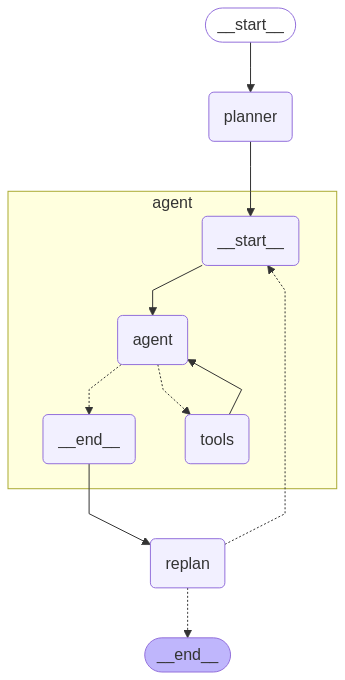

In [46]:


from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))



In [47]:


config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)



{'plan': ["Identify the winner of the men's 2024 Australian Open.", 'Research the hometown of the identified winner.', 'Provide the hometown as the final answer.']}
{'past_steps': [("Identify the winner of the men's 2024 Australian Open.", "The winner of the men's singles title at the 2024 Australian Open is Jannik Sinner from Italy.")]}


APIConnectionError: Connection error.